In [13]:
from qiskit import QuantumCircuit, Aer, IBMQ
from qiskit import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import plot_histogram
from matplotlib.pyplot import *
from math import log2, ceil, pi, sqrt, acos
%matplotlib inline

# Reading Image File

In [15]:
image_number = 1 #There are total 3 sample images

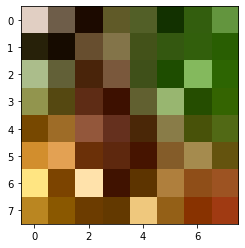

In [16]:
options= ["8x8","16x16","32x32"]
image_name= "images\Salad_"+options[image_number-1]+".jpg"
im= imread(image_name)
imshow(im)

## If the size of the color image is $2^n \times 2^n $, we will split the R, G, B part and construct a $2^{n+1} \times 2^{n+1} $ grey image. By this method, only 2 additional  qubits will be required to encode a color image instead of grey image. 

In [17]:
dim= im.shape[0];
n= int(log2(dim));
colors = []
for i in range(4): #R,G,B part
    for j in range(dim):
        if i==3:
            colors = colors + list(0*im[:,j,0])
        else:
            for k in im[:,j,i]:
                colors.append(k)
total= len(colors)
c= 2*n+2; #total number of control qubits
#print(colors, total)

# Firstly we will implement NEQR Algorithm. If the size of color image is $2^n \times 2^n$, we will need $8$ qubits to encode the color and and $2n+2$ qubits to store position Information.

# In [Novel Enhanced Quantum Representation (NEQR)](https://qiskit.org/textbook/ch-applications/image-processing-frqi-neqr.html), 
we can express a $2^n \times 2^n $ grey scale image as $$ \mid{I}\rangle= \frac{1}{2^n}\sum_{Y=0}^{2^n-1} \sum_{X=0}^{2^n-1}|{f(Y,X)}\rangle|{YX}\rangle$$
Here, $|{f(Y,X)}\rangle= \otimes_{i=0}^{i=q-1} \mid C_{YX}^i\rangle $ encodes pixel information, where $q=8$ for grey scale image. $ C_{YX}^i \in \{0,1\} $

In [18]:
from numpy import *
from qiskit import QuantumRegister, ClassicalRegister

position = QuantumRegister(2*n+2, 'position')
intensity = QuantumRegister(8,'intensity')
cr = ClassicalRegister(2*n+10, 'cr')
NEQR = QuantumCircuit(intensity, position, cr)
controls = list(range(intensity.size, NEQR.num_qubits))
NEQR.h(controls)   
NEQR.barrier()
#NEQR.draw(output='mpl')

Now we will encode the position information by putting $X$ gates in the front and back of Tofolli Gates. We will first determine the position of X Gates

In [19]:
def xposition(i,c): 
    lst=[]
    for j in range(c):
        if i%2==0:
            lst.append(j)
        i=int(i/2)
    return lst

In [20]:
for i in range(total):
    j=total-i-1;
    if(colors[j]==0):
        continue
    xp_= xposition(j,2*n+2)
    xp= [x+8 for x in xp_] #X gate position
    NEQR.x(xp)
    tpos_= xposition(colors[j],8)
    for i in range(8):
        if i not in tpos_:
            NEQR.mct(controls,i)
    NEQR.x(xp)
    NEQR.barrier()
NEQR.barrier()
NEQR.measure(range(NEQR.num_qubits),range(NEQR.num_qubits))

In [9]:
NEQR.draw(output='mpl')

## Decoding  + Recostructing Image 

In [21]:
shot= 8192*8;
aer_sim = Aer.get_backend('aer_simulator')
t_NEQR = transpile(NEQR, aer_sim)
#qobj = assemble(t_NEQR, shots=shot)
job_neqr = aer_sim.run(t_NEQR,shot, memory=True)
result_neqr = job_neqr.result()
counts_neqr = result_neqr.get_counts()

print(counts_neqr)
#plot_histogram(counts_neqr)

TypeError: bad input to run() function;`validation` argument is only effective for input qobj

In [10]:
results= list(counts_neqr.keys())
count= 0;
def str2dec(st):
    n= int(st); 
    s=0; k=1;
    while n>0:
        s=s+k*(n%10);
        n=int(n/10)
        k=k*2;
    return s

In [11]:
new_pixel= [0 for i in range(total)];
for i in results:
    pos= str2dec(i[:-8]) #Last 8 are pixel info.
    pixel= str2dec(i[-8:])
    new_pixel[pos]= pixel
#print(new_pixel)

#### NEW IMAGE RECONSTRUCTION 

#### Square Error 

In [12]:
from numpy import *
new_image = zeros( (dim,dim,3), dtype=np.uint8)
R=[]; G=[]; B=[];
for i in range(dim):
    for j in range(dim):
        R.append(new_pixel[i+j*dim])
for i in range(dim):
    for j in range(dim):
        G.append(new_pixel[dim*dim+i+j*dim])
for i in range(dim):
    for j in range(dim):
        B.append(new_pixel[2*dim*dim+i+j*dim])
modified_pixel = R+G+B; 
for i in range(3):
    for j in range(dim):
        count=0
        for k in modified_pixel[(i*dim+j)*dim:dim*(j+1+i*dim)]:
            new_image[j,count,i]= k;
            count = count + 1;

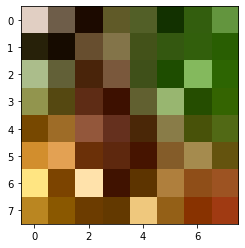

In [13]:
from PIL import Image
img = Image.fromarray(new_image, 'RGB')
img.save('NEQR'+options[image_number-1]+'.png')
imshow(img) # I don't why no color is showing!! There is not error!

In [14]:
sqerr= 0;
count = 0;
for i in range(3*dim*dim):
    if colors[i] != new_pixel[i]:
        try:
            sqerr = sqerr + ((colors[i]-new_pixel[i])/colors[i])**2;
        except ZeroDivisionError:
            sqerr = sqerr + 1;
        count = count + 1;
    
error = 100*sqrt(sqerr/(total))
print("Mean Square Error = ", error, "%\nTotal Error position = ", count, " out of total pixels = ", total)


Mean Square Error =  0.0 %
Total Error position =  0  out of total pixels =  256


**We see that the error is not very significant!**

# We will now use the FRQI algorithm, hence encode the pixel data in angles (requires one qubit). For color image we will encode, $$\theta_i=cos^{-1}(\frac{R_i}{256}+\frac{G_i}{256^2}+\frac{B_i}{256^3})$$ The advantage is, given $\theta_i$ we can easily get correspondent $R_i, G_i, B_i$ by expressing $256^3cos(\theta_i)$ as $256$ base number. 

In [15]:
angles= []; count=0;
for i in range(dim):
    for j in range(dim):
        base=256; s=0;
        for k in range(3):
            s = s + im[i,j,k]/base;
            base = base * 256;
        angles.append(s)
        count = count + 1
#print(angles)
c= 2*n;

# Encoding in Quantum Circuit

### [Flexible Representation of Quantum Images (FRQI) encoding](https://qiskit.org/textbook/ch-applications/image-processing-frqi-neqr.html)
Given $$\{\theta_0, \theta_1, ..., \theta_{4^{n}-1}\}  \quad  (\theta_i \in [0,\pi/2])$$ we can transform $\mid{0}\rangle^{\otimes2n+1}$ into FRQI state $\mid{I(\theta)}\rangle$ by applying unitary operator $\mathcal{R}\mathcal{H}$, with $\mathcal{H}= I \otimes H^{\otimes 2n}$ and $\mathcal{R}= \prod_{i=0}^{4^n-1}R_i$. where $$\mid{I(\theta)}\rangle= \frac{1}{2^n}\sum_{i=0}^{4^n-1}(cos \theta_i|{0}\rangle+sin \theta_i|{1}\rangle)\otimes |{i}\rangle$$ 

And $R_i$ is a unitary matrix named **controlled rotation**, given by
$$R_i= I \otimes \sum_{j=0, j \neq i}^{4^n-1} |{j}\rangle \langle {j}| + R_y(2\theta_i) \otimes  |{i}\rangle \langle {i}| = I^{\otimes 2n+1}+(R_y(2\theta_i)-I) \otimes  |{i}\rangle \langle {i}\mid$$
We can implement the controlled rotation $R_i$'s using $C^{2n}R_y$ (controlled $R_y$) and $X$ gate. Here, $$ C^{2n}R_y(2\theta_i)= I^{\otimes 2n+1}+(R_y(2\theta_i)-I) \otimes  |{4^n-1}\rangle \langle {4^n-1}\mid $$

We can convert $C^{2n}R_y$ into $R_i$ by applying NOT gates in the left and right side.
 

In [16]:
from qiskit.circuit.library.standard_gates import RYGate
cntrl= list(range(c));

Basically, X gates are applied in the positions of zero binary digit for correspondent basis. 

We will first determine the position of X Gates to convert $C^{2n}.R_y$ gates in $R_$i gate. We can use the identity $X^2=I$ to minimize total gates.

In [17]:
def Xpos(i,c,lr,count): #Minimizing
    lst=[]
    list1= xposition(i,c);
    if(count==0):
        return list1
    if(lr=="Left"):
        list2 = xposition(i+1,c)
    elif(lr=="Right"):
        list2= []
        if i>0:
            list2 = xposition(i-1,c)
    for j in list1:
        if (j not in list2):
            lst.append(j)
    return lst

Basically we are converting $C^{2n}R_y$ in $R_i$. For example, in case of $2\times 2$ grey image, we see, $R_3= C^2R_y$, and $$R_2= (I \otimes I \otimes X) C^2R_y (I \otimes I \otimes X)$$
$$R_1= (I \otimes X \otimes I) C^2R_y (I \otimes X \otimes I)$$
$$R_0= (I \otimes X \otimes X) C^2R_y (I \otimes X \otimes X)$$
Therefore controlled rotations $R_i$ can be implemented by $C^{2n}R_y(2θ_i)$ and NOT operations.

Basically, applying $I \otimes P_i $ in the both side of $C^{2n}R_y$ to make the conversion:
$$ P_i |{4^n-1}\rangle = |{i}\rangle $$ Here $P_i$ is tensor product of some $I$ and $X$, which is definitely harmitian.

In [18]:
FRQI= QuantumCircuit(c+1,c+1);
FRQI.h(cntrl);
count=0; total=len(angles)
for i in range(total):
    j=total-i-1;
    if(angles[j]==0):
        continue
    left= Xpos(j,c,"Left",count);
    if left!=[]:
        FRQI.x(left)
    count= count+1
    CRy= RYGate(2*angles[j]).control(c); #C^{2n}R_y gate
    FRQI.append(CRy,cntrl+[c])
    right= Xpos(j,c,"Right",count);
    if right!=[]:
        FRQI.x(right)
FRQI.measure(range(c+1),range(c+1))

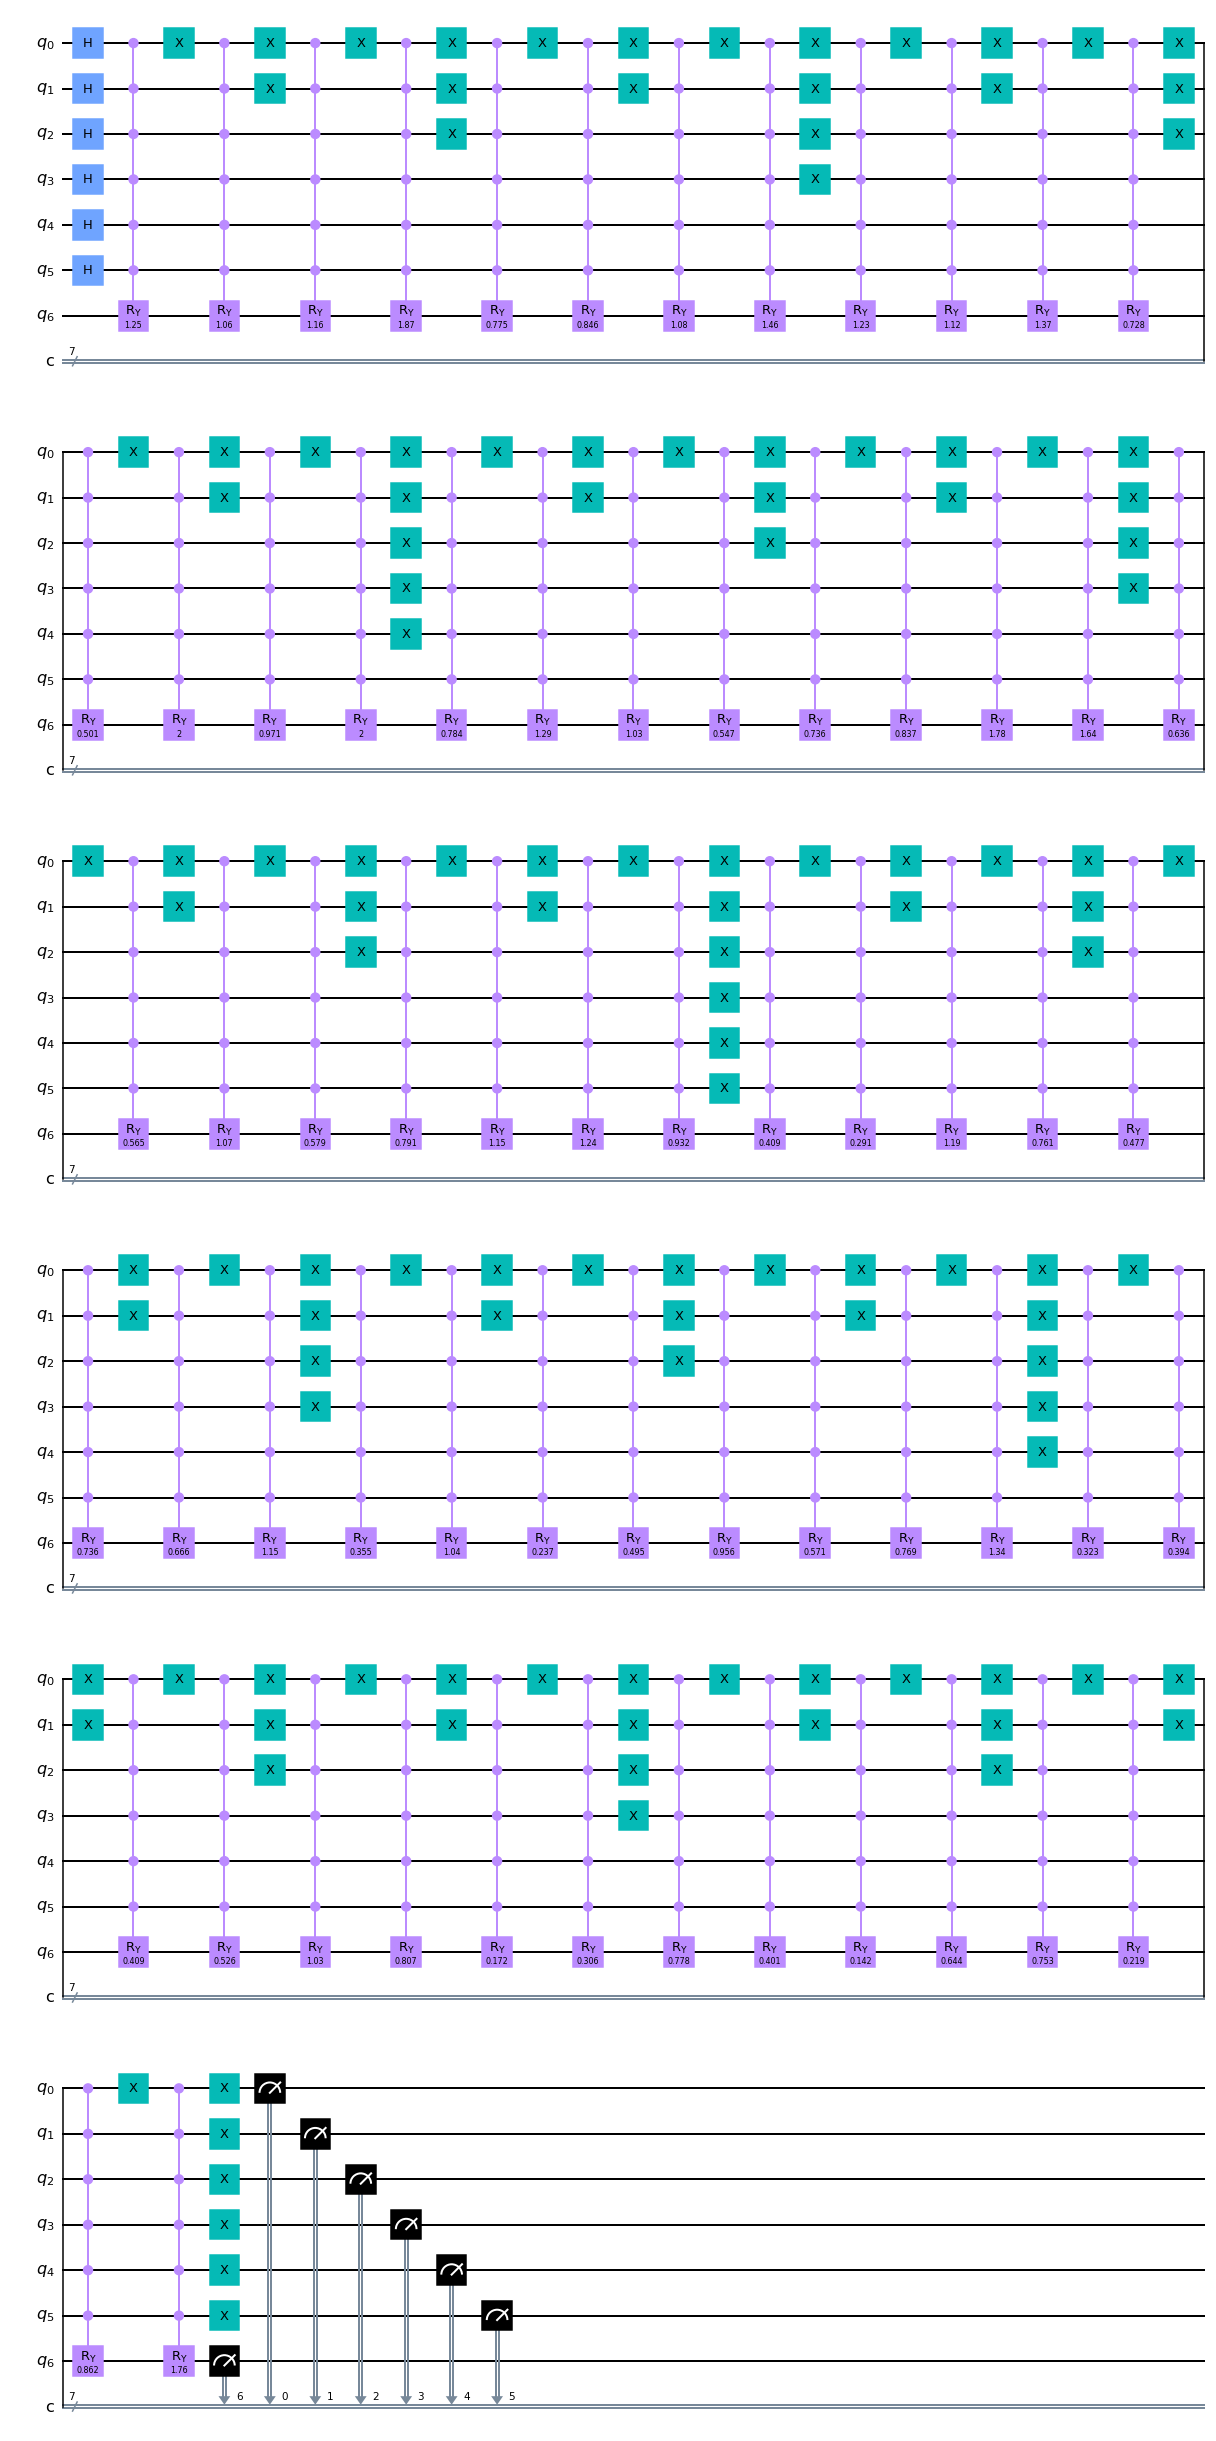

In [19]:
FRQI.draw(output="mpl")

In [20]:
aer_sim = Aer.get_backend('aer_simulator')
t_FRQI = transpile(FRQI, aer_sim)
qobj = assemble(t_FRQI, shots=shot)
result_frqi = aer_sim.run(qobj).result()
counts_frqi = result_frqi.get_counts(FRQI)

### Decoding  + Recostructing Image 

In [25]:
results_= list(counts_frqi.keys())
results = []
for i in results_:
    if (i[:-1] not in results):
        results.append(i[:-1])
total = 2**c; 
count= 0;
R= [0 for i in range(total)];
temp = [0 for i in range(total)];
G = [0 for i in range(total)];
B = [0 for i in range(total)];
R = [0 for i in range(total)];

for i in results:
    pos= str2dec(i) #Last 1 is pixel info.
    try:
        k1= counts_frqi['0'+i]
    except:
        k1=0
    try:
        k2= counts_frqi['1'+i]
    except:
        k2=0
    try:
        k= sqrt((k1)/(k1+k2))
    except:
        k=0;
    k = int(round(k*(256)**3));
    temp[pos] = k;
    B[pos] = k%256;
    k = int(k / 256);
    G[pos] = k%256;
    k = int(k / 256);
    R[pos] = k%256;

In [26]:
new_img = zeros( (dim,dim,3), dtype=np.uint8)
for j in range(dim):
    for k in range(dim):
        new_img[j,k,0]= R[j*dim+k];
        new_img[j,k,1]= G[j*dim+k];
        new_img[j,k,2]= B[j*dim+k];

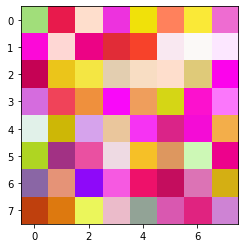

In [27]:
img_ = Image.fromarray(new_img, 'RGB')
img_.save('FRQI'+options[image_number-1]+'.png')
imshow(img_) 

In [28]:
sqerr= 0;
count = 0;
for i in range(dim):
    for j in range(dim):
        for k in range(3):
            if im[i,j,k] != new_img[i,j,k] :
                if im[i,j,k]!=0:
                    sqerr = sqerr + ((im[i,j,k] - new_img[i,j,k])/im[i,j,k] )**2;
                else:
                    sqerr = sqerr + 1;
                count = count + 1;

error = sqrt(sqerr/(3* total))
print("Mean Square Error = ", error, "(not in %)\nTotal Error position = ", count, " out of total pixels = ", 3*total)

Mean Square Error =  3.395083002242454 (not in %)
Total Error position =  192  out of total pixels =  192


C:\Users\User\AppData\Local\Temp/ipykernel_10400/2692191738.py:8: RuntimeWarning: overflow encountered in ubyte_scalars
  sqerr = sqerr + ((im[i,j,k] - new_img[i,j,k])/im[i,j,k] )**2;


# Conclusion

**NEQR seems better than FRQI although it needs more qubits. In NEQR, all states are equally probable but in FRQI the states are not equally probable. Hence the less the shot number, the less accurate image will be constructed.**